# CS 179 Collaborative Filtering Project

***
***Group Member***: Chenhao Li, Chaoyuan Hsueh, Bowen Lu
***

## Abstract

Collaborative filtering is a technique used by recommander systems, which its usage is to predict the user's taste (rating) on a specific item by collecting preferences or taste information from many other users. There are two major methods for computation in collaborative filtering algorithm: memory based collaborative filtering and model based collaborative filtering.In this project, we are going to ev on both memory based and model based methods. And we are going to discuss the difference of results these two methods yield.

***

## Data

The data we use is MovieLens 100k, which contains 100000 movie ratings from 943 users on 1682 movies. For each row of the data file, it contains: the user id, movie id which theuser rates, the rating of the movie, and the time stamp. Each user rates at least 20 movies. We will preprocess the data into two sets: training set and testing set.

In [2]:
import numpy as np
import pandas as pd

# The rating data file
column_names = ['user_id','item_id','rating','timestamp']
df = pd.read_csv('data/u.data', sep='\t', names=column_names)

# 75% data as train_data, 25% as test_data
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=0.25)

In [4]:
# We then build training and testing matrix for convenience
# Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]  
test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

***
## Procedure

### a) Memory Based Filtering

There are two main approaches for memory-based collaborative filtering: User-item filitering and Item-item filtering

User-item:
 A user-item filtering is using specific user data to provide recommendation. Based on the similarity of ratings for each provided user, the filiter will find the users who are similar to him, and gives them some recomendations of items, as "the users similar to you are also like....."  
        
Item-item:
 A Item-Item filtering is using specific item data to find similar taste users. After finding those users, the system will look for other items that these users also like and return them, as "the users like this item are also like....."

We need to build two matrices for testing and training:  
For User-item CF, observing two users to calculating the similarity between these two users.  
For item-item CF, observing all users who using the two items, and then calculat the items similarity.

In [5]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

After creating the similarity matrices, we can use the following User-item CF fomula:
    <img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?\hat{x}_{k,m}&space;=&space;\bar{x}_{k}&space;&plus;&space;\frac{\sum\limits_{u_a}&space;sim_u(u_k,&space;u_a)&space;(x_{a,m}&space;-&space;\bar{x_{u_a}})}{\sum\limits_{u_a}|sim_u(u_k,&space;u_a)|}"/>


This formula emphasizes on the similarity and relativity between the difference of rating for each person. As every user has his/her subjective rating range, poeple may rate movie differently which their gives all movies a higher or lower score. Thus the differences and relative positions of each person's rating are much more important comparing to the absolute values of the movie scores.

Because we will do the predictions when we finding the user in Item-item CF, so we won't need to make prediction again to update the user rating.

Thus, we have this fomula:
    <img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?\hat{x}_{k,m}&space;=&space;\frac{\sum\limits_{i_b}&space;sim_i(i_m,&space;i_b)&space;(x_{k,b})&space;}{\sum\limits_{i_b}|sim_i(i_m,&space;i_b)|}"/>

In [19]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = (mean_user_rating[:, np.newaxis] + 
                similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T)
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred

In [7]:
#Both item and user prediction contain the rating preferences for each item per user
item_prediction = predict(train_data_matrix, item_similarity, type='item')
user_prediction = predict(train_data_matrix, user_similarity, type='user')
print(user_prediction.shape)

(943, 1682)


### b) Model Based Filtering

There are lots of methods used in model-based collaborative filtering. Here, we are going to explore the method by using singular value decomposition (SVD).  

SVD is a matrix factorization technique that is usually used to reduce the number of features of a data set by reduing the space dimensions from N to K. When it is used in the collaborative filtering, it can help us to learn the latent preferences of users and the latent attributes of items from known rating. Latent variables are those not shown in the data. For example, from the dataset we can get information of user id, age, location, gender, movie id, director, actor, language, year, rating. After matrix factorization, the model can learns users' agfe group, such as under 10, 10- 18, 18- 30, etc. For movie feature, it can also learns that decade, director, and actor are most important. However, if looking into the information we have, decade is not a known feature from the dataset.

SVD can be decribed as for a given $m\times n$ matrix X, it can be factorized as:
$$X = USV^T$$

where 
* U is a $m\times r$ orthogonal matrix represents the feature vectors corresponding to the users in the hidden feature space.
* S is a $r\times r$ diagonal matrix with non-negative real number represents the singular value of X.
* $V^T$ is a $r\times n$ orthogonal matrix represents the feature vectors corresponding to the items (movies here) in the hidden space

In [8]:
from scipy.sparse.linalg import svds

k = [1,5,10,20,50]
v_pred = []

for ik in k:
    #get SVD components from train matrix. Choose k.
    u, s, vt = svds(train_data_matrix, k = ik)
    s_diag_matrix=np.diag(s)
    X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
    v_pred.append(X_pred)

***
## Evaluation

A lot of methods for evaluation are used, but one of the most popular metric used is *Root Mean Square Error (RMSE)*
$$RMSE=\sqrt{\frac{1}{N}\sum (x_i-\hat{x}_i)^2}$$
Since we only want to compare the accuracy based on the ratings in test set, we will filter out all other elements in prediction that are not in testing matrix.

In [9]:
from sklearn.metrics import mean_squared_error
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return np.sqrt(mean_squared_error(prediction, ground_truth))

In [10]:
#compute RMSE for each filiter method
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Model-based CF RMSE: ' + str(rmse(X_pred, test_data_matrix)))

Item-based CF RMSE: 3.4478014783179467
User-based CF RMSE: 3.1199993115637965
Model-based CF RMSE: 2.958812186009235


Moreover, for model based methods, we want to see how different k will influence the result

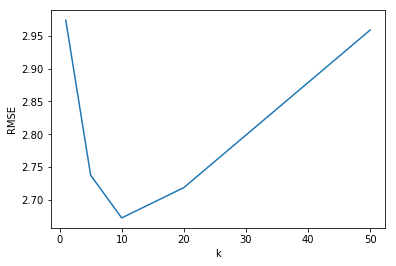

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

y = [rmse(x, test_data_matrix) for x in v_pred]
plt.plot(k,y)
plt.xlabel('k')
plt.ylabel('RMSE')
plt.show()

***
## Conclusion

We can see the prediction from Model-based Collaborative Filtering is better than the two methods in Memory-based algorithms, as Model-based CF has the least RMSE value.In general, Model-based CF involves building a model based on the dataset of ratings.We can use that model to make recommendations without having to use the complete dataset every time.As a result, the Model-based CF approach offers the benefits of both speed and scalability. On the other hand, for Memory-based CF, although it is relativly easy to be implemented, memory-based CF doesn't scale, which it doesn't address well when new user or new item are added to the system. Moreover, memory-based method needs a good similarity evaluation in order to find a good neighbor, and it needs rating as many as possible. Otherwise, it cannot perform well prediction as there is limited number of ratings is known. However, for model based method, we can use latent variables to predict result even though there are some items that are not rated by users.

We can see that in the model based method, choosing different k value will yield different results. It is because that we have to consider enough variables to form reasonable model. Too limitd variable will not provide enough information to construct predictions correctly. While there are many variables, some of them are useless which they give incorrect information for our predictions. More precisely, the data we use do not have enough ratings, that users may not rate as many movies as when each of them only rate 20 movies. Even though model based method will use latent variables,  there won't be enough "useful" latent variables we can use as we let k to be large.

***
## Acknowledgment

We read the paper "Model-based approach for Collaborative Filtering" written by Do, Dung Van Nguyen, and Loc Nguyen. And we find a [tutorial](https://github.com/shivang98/Recommendation-Engine) from Shivang Agarwal that relates to some contents described in the paper.